# Определение перспективного тарифа для телеком-компании

Описание: Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

### Открываем таблицу с информацией о пользователях:

Импортируем необходимые библиотеки:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

In [ ]:
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


По таблице о пользователях нам известно, что:

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Из видимых на первый взгляд проблем в столбце reg_date тип данных object, его лучше изменить на datetype.

### Открываем таблицу с информацией о тарифах:

In [ ]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


По таблице с информацией о тарифах известно, что:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

В таблице с информацией о тарифах никаких проблем нет, все данные нужных типов.

### Открываем таблицу с информацией о звонках:

In [ ]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


По таблице с информацие о звонках нам известно, что:

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

В этой таблице пропусков нет, стоит изменить тип данных столбца call_date на datetype.

### Открываем таблицу с информацией о сообщениях:

In [ ]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


По таблице с информацией о сообщениях нам известно, что:

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

В этой таблице пропусков нет, стоит изменить тип данных столбца message_date на datetype

### Открываем таблицу с информацией о трафике

In [ ]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


По таблице с информацией об интернет-трафике нам известно, что:

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

При открытии таблицы мы увидели, что в таблице присутствует лишний столбец, дублирующий индексы, поэтому сразу его удалим. Также необходимо будет преобразовать тип данных столбца session_date к типу datetype

In [ ]:
internet = internet.loc[:,'id':'user_id']
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**Вывод**

Для решения данного проекта у нас доступно 5 таблиц с информацией о пользователях, их тратах по мобильным тарифам и о самих тарифах. 

Предварительно можно утверждать, что, данных достаточно для ответа на поставленные вопросы и для определения истинности гипотез. Но встречаются некоторые проблемы в данных описсанные ранее.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Замена типов данных

#### Замена типа данных в таблице users

In [ ]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [ ]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


#### Замена типа данных в таблице calls

In [ ]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


#### Замена типа данных в таблице messages

In [ ]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


#### Замена типа данных в таблице internet

In [ ]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [ ]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


### Обработка дубликатов

Проверим все таблицы (users, calls, messages, internet) на наличие дубликатов и устраним если такие есть:

#### Работа с users:

In [ ]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Предварительно преобразуем столбцы city, first_name, last_name к нижнему регистру:

In [ ]:
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1001,41,NaN,москва,иван,ежов,2018-11-01,smart
2,1002,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart
3,1003,23,NaN,москва,белла,белякова,2018-08-17,ultra
4,1004,68,NaN,новокузнецк,татьяна,авдеенко,2018-05-14,ultra


In [ ]:
users.duplicated().sum()

0

#### Работа с calls:

In [ ]:
calls.duplicated().sum()

0

#### Работа с messages:

In [ ]:
messages.duplicated().sum()

0

#### Работа с internet:

In [ ]:
internet.duplicated().sum()

0

### Поиск ошибок и аномалий в данных

#### Работа с таблицей users

In [ ]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1001,41,NaN,москва,иван,ежов,2018-11-01,smart
2,1002,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart
3,1003,23,NaN,москва,белла,белякова,2018-08-17,ultra
4,1004,68,NaN,новокузнецк,татьяна,авдеенко,2018-05-14,ultra


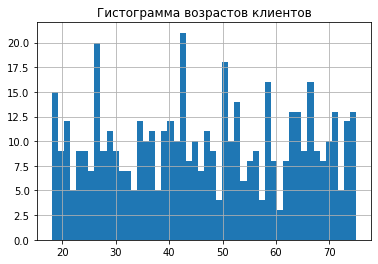

In [ ]:
users['age'].hist(bins=50)
plt.title('Гистограмма возрастов клиентов')
plt.show()

Никаких аномалий и ошибок в таблице users не было найдено.

#### Работа с таблицей calls

In [ ]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


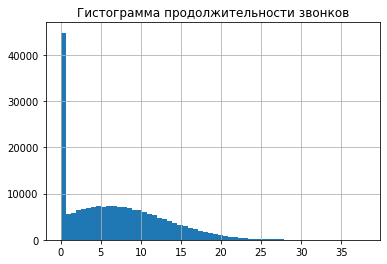

In [ ]:
calls['duration'].hist(bins=60)
plt.title('Гистограмма продолжительности звонков')
plt.show()

Судя по распределению продолжительности звонков можно сказать, что значительная часть данных это пропущенные вызовы, а в среднем вызовы длятся 5-10 минут. Как таковых ошибок здесь нет.

#### Работа с таблицей messages

In [ ]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
messages.groupby('user_id')['id'].count().sort_values()

user_id
1141       1
1159       2
1074       3
1279       5
1111       6
        ... 
1356    1224
1385    1380
1231    1384
1089    1408
1277    1463
Name: id, Length: 426, dtype: int64

По таблице с сообщениями видно, что есть те, кто отправил всего 1 смс, а есть те кто отправляет более тысячи. Ошибок здесь также нет, поскольку есть пользователи которые активно общаются при помощи смс, а есть те кто ими практичски не пользуется.

#### Работа с таблицей internet

In [ ]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


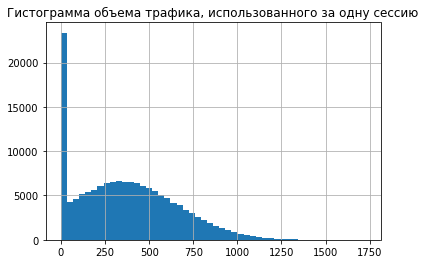

In [ ]:
internet['mb_used'].hist(bins = 50)
plt.title('Гистограмма объема трафика, использованного за одну сессию')
plt.show()

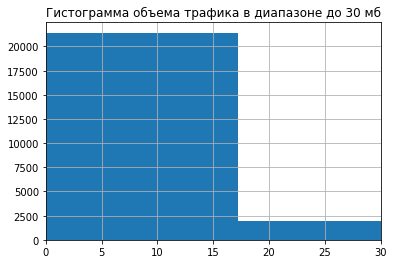

In [ ]:
internet['mb_used'].hist(bins=100)
plt.xlim(0, 30)
plt.title('Гистограмма объема трафика в диапазоне до 30 мб')
plt.show()

Гистограмма распределения объема трафика показала, что значительная часть интернет-сессий это до 20 мб. Но те пользователи что сидят за одну сессию дольше в среднем тратят 400 мб.

**Вывод**

Мы предобработали все таблицы, заменили типы данных некоторых столбоц на нужные. Различные проверки показали что как таковых ошибок в данных нет, значит теперь можно переходить к анализу.

Создадим функцию для первичной проверки данных:

In [ ]:
def hello_data(data):
    display('Вывод первых строк таблицы', data.head())
    display('Информация о данных:')
    data.info()
    display('Числовое описание данных', data.describe())
    display('Гистограммы по таблице', data.hist(bins = 30, figsize = (10,5)))

'Вывод первых строк таблицы'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1001,41,NaN,москва,иван,ежов,2018-11-01,smart
2,1002,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart
3,1003,23,NaN,москва,белла,белякова,2018-08-17,ultra
4,1004,68,NaN,новокузнецк,татьяна,авдеенко,2018-05-14,ultra


'Информация о данных:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


'Числовое описание данных'

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


'Гистограммы по таблице'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e73b7d10>,
      dtype=object)

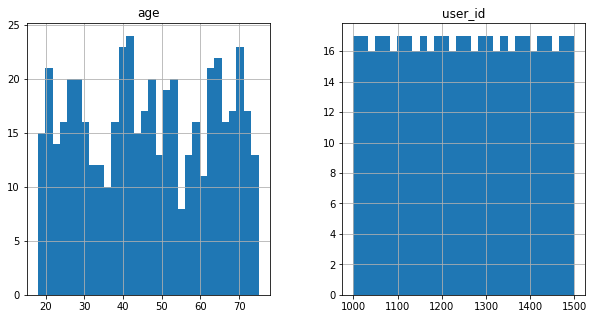

In [ ]:
hello_data(users)

'Вывод первых строк таблицы'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


'Информация о данных:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


'Числовое описание данных'

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


'Гистограммы по таблице'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e71e8110>,
      dtype=object)

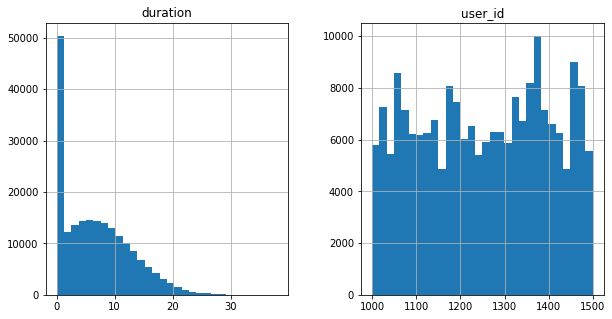

In [ ]:
hello_data(calls)

'Вывод первых строк таблицы'

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


'Информация о данных:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


'Числовое описание данных'

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


'Гистограммы по таблице'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e7152250>]],
      dtype=object)

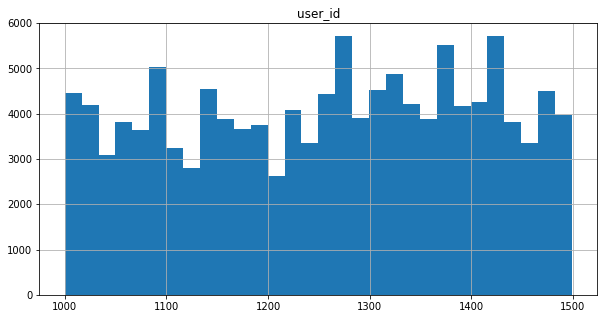

In [ ]:
hello_data(messages)

'Вывод первых строк таблицы'

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


'Информация о данных:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


'Числовое описание данных'

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


'Гистограммы по таблице'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e7281f90>,
      dtype=object)

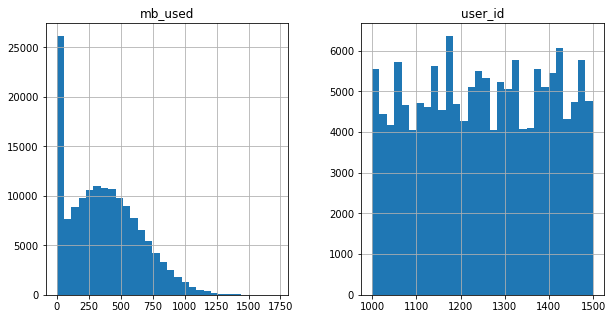

In [ ]:
hello_data(internet)

## Расчёты и добавление результатов в таблицу

Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Добавим количество сделанных звонков и израсходованных минут разговора по месяцам:

In [ ]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Добавим столбец с месяцем в таблицу:

In [ ]:
calls['month'] = calls['call_date'].dt.to_period('M')
calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,2018-07
1,1000_1,2018-08-17,0.00,1000,2018-08
2,1000_2,2018-06-11,2.85,1000,2018-06
3,1000_3,2018-09-21,13.80,1000,2018-09
4,1000_4,2018-12-15,5.18,1000,2018-12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,2018-12
202603,1499_216,2018-10-18,18.83,1499,2018-10
202604,1499_217,2018-11-10,10.81,1499,2018-11
202605,1499_218,2018-10-06,4.27,1499,2018-10


Выполним округление продолжительности телефоных разговоров в большую сторону:

In [ ]:
def round_duration(duration):
     return math.ceil(duration)
calls['duration'] = calls['duration'].apply(round_duration)
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,2018-07
1,1000_1,2018-08-17,0,1000,2018-08
2,1000_2,2018-06-11,3,1000,2018-06
3,1000_3,2018-09-21,14,1000,2018-09
4,1000_4,2018-12-15,6,1000,2018-12


Рассчитаем сколько каждый пользователь минут потратил за каждый месяц и сколько раз звонил:

In [ ]:
calls_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_grouped = calls_grouped.reset_index()
calls_grouped.columns = ['user_id', 'month', 'count_calls', 'sum_duration']
calls_grouped

,user_id,month,count_calls,sum_duration
0,1000,2018-05,22,159
1,1000,2018-06,43,172
2,1000,2018-07,47,340
3,1000,2018-08,52,408
4,1000,2018-09,58,466
...,...,...,...,...
3169,1498,2018-10,41,247
3170,1499,2018-09,9,70
3171,1499,2018-10,68,449
3172,1499,2018-11,74,612


###  Добавим количество отправленных сообщений по месяцам

In [ ]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [ ]:
messages['month'] = messages['message_date'].dt.to_period('M')
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06
1,1000_1,2018-10-08,1000,2018-10
2,1000_2,2018-08-04,1000,2018-08
3,1000_3,2018-06-16,1000,2018-06
4,1000_4,2018-12-05,1000,2018-12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,2018-12
123032,1499_180,2018-09-28,1499,2018-09
123033,1499_181,2018-09-27,1499,2018-09
123034,1499_182,2018-11-15,1499,2018-11


In [ ]:
messages_grouped = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_grouped = messages_grouped.reset_index()
messages_grouped.columns = ['user_id', 'month', 'messages_count']
messages_grouped

,user_id,month,messages_count
0,1000,2018-05,22
1,1000,2018-06,60
2,1000,2018-07,75
3,1000,2018-08,81
4,1000,2018-09,57
...,...,...,...
2712,1498,2018-10,42
2713,1499,2018-09,11
2714,1499,2018-10,48
2715,1499,2018-11,59


###  Добавим объем израсходованного интернет-трафика по месяцам

In [ ]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


Добавим столбец с месяцем:

In [ ]:
internet['month'] = internet['session_date'].dt.to_period('M')
internet

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11
1,1000_1,1052.81,2018-09-07,1000,2018-09
2,1000_2,1197.26,2018-06-25,1000,2018-06
3,1000_3,550.27,2018-08-22,1000,2018-08
4,1000_4,302.56,2018-09-24,1000,2018-09
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,2018-10
149392,1499_153,490.13,2018-12-14,1499,2018-12
149393,1499_154,0.00,2018-10-27,1499,2018-10
149394,1499_155,1246.32,2018-11-26,1499,2018-11


In [ ]:
internet_grouped = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_grouped = internet_grouped.reset_index()
internet_grouped.columns = ['user_id', 'month', 'sum_mb_used']
internet_grouped

,user_id,month,sum_mb_used
0,1000,2018-05,2253.49
1,1000,2018-06,23233.77
2,1000,2018-07,14003.64
3,1000,2018-08,14055.93
4,1000,2018-09,14568.91
...,...,...,...
3198,1498,2018-10,20579.36
3199,1499,2018-09,1845.75
3200,1499,2018-10,17788.51
3201,1499,2018-11,17963.31


Округлим объем трафика за месяц согласно тарифу оператора:

Создадим функцию для округления трафика:

In [ ]:
def round_internet(mb_used):
    mb_reminder = mb_used % 1024
    if mb_reminder > 0:
        gb = mb_used // 1024 + 1
    if mb_reminder == 0:
        gb = mb_used // 1024
    return gb

test_mb = 1025
display(round_internet(test_mb))
test_mb = 1024
display(round_internet(test_mb))
test_mb = 1023
display(round_internet(test_mb))

2

1

1

In [ ]:
internet_grouped['sum_gb_used'] = internet_grouped['sum_mb_used'].apply(round_internet)
internet_grouped

,user_id,month,sum_mb_used,sum_gb_used
0,1000,2018-05,2253.49,3.0
1,1000,2018-06,23233.77,23.0
2,1000,2018-07,14003.64,14.0
3,1000,2018-08,14055.93,14.0
4,1000,2018-09,14568.91,15.0
...,...,...,...,...
3198,1498,2018-10,20579.36,21.0
3199,1499,2018-09,1845.75,2.0
3200,1499,2018-10,17788.51,18.0
3201,1499,2018-11,17963.31,18.0


### Добавим помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

Объединим все таблицы в одну для дальнейшего анализа:

In [ ]:
calls_grouped

,user_id,month,count_calls,sum_duration
0,1000,2018-05,22,159
1,1000,2018-06,43,172
2,1000,2018-07,47,340
3,1000,2018-08,52,408
4,1000,2018-09,58,466
...,...,...,...,...
3169,1498,2018-10,41,247
3170,1499,2018-09,9,70
3171,1499,2018-10,68,449
3172,1499,2018-11,74,612


In [ ]:
messages_grouped

,user_id,month,messages_count
0,1000,2018-05,22
1,1000,2018-06,60
2,1000,2018-07,75
3,1000,2018-08,81
4,1000,2018-09,57
...,...,...,...
2712,1498,2018-10,42
2713,1499,2018-09,11
2714,1499,2018-10,48
2715,1499,2018-11,59


In [ ]:
internet_grouped

,user_id,month,sum_mb_used,sum_gb_used
0,1000,2018-05,2253.49,3.0
1,1000,2018-06,23233.77,23.0
2,1000,2018-07,14003.64,14.0
3,1000,2018-08,14055.93,14.0
4,1000,2018-09,14568.91,15.0
...,...,...,...,...
3198,1498,2018-10,20579.36,21.0
3199,1499,2018-09,1845.75,2.0
3200,1499,2018-10,17788.51,18.0
3201,1499,2018-11,17963.31,18.0


Объединим таблицы в одну для удобства анализа:

In [ ]:
users_new = users[['user_id', 'tariff']]
data = pd.DataFrame()
data = internet_grouped
data = data.merge(calls_grouped, on=['user_id', 'month'], how='outer')
data = data.merge(messages_grouped, on=['user_id', 'month'], how='outer')
data = data.merge(users_new, on=['user_id'], how='outer')
data

,user_id,month,sum_mb_used,sum_gb_used,count_calls,sum_duration,messages_count,tariff
0,1000,2018-05,2253.49,3.0,22.0,159.0,22.0,ultra
1,1000,2018-06,23233.77,23.0,43.0,172.0,60.0,ultra
2,1000,2018-07,14003.64,14.0,47.0,340.0,75.0,ultra
3,1000,2018-08,14055.93,14.0,52.0,408.0,81.0,ultra
4,1000,2018-09,14568.91,15.0,58.0,466.0,57.0,ultra
...,...,...,...,...,...,...,...,...
3211,1273,2018-10,NaN,NaN,40.0,315.0,35.0,ultra
3212,1273,2018-11,NaN,NaN,45.0,272.0,29.0,ultra
3213,1273,2018-12,NaN,NaN,41.0,260.0,39.0,ultra
3214,1128,NaT,NaN,NaN,NaN,NaN,NaN,ultra


Теперь понятно куда в прошлый раз пропали 2 человека, это были люди с отстутствующим месяцем

In [ ]:
data.shape

(3216, 8)

In [ ]:
data.user_id.nunique()

500

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
user_id           3216 non-null int64
month             3214 non-null period[M]
sum_mb_used       3203 non-null float64
sum_gb_used       3203 non-null float64
count_calls       3174 non-null float64
sum_duration      3174 non-null float64
messages_count    2717 non-null float64
tariff            3216 non-null object
dtypes: float64(5), int64(1), object(1), period[M](1)
memory usage: 226.1+ KB


Пропуски в этой таблице показывают, что есть пользователи которые в определенном месяце не используют звонки, смс или интернет. Эти пропуски целесообразно заменить на нули.

In [ ]:
columns = ['count_calls', 'sum_duration', 'messages_count', 'sum_mb_used', 'sum_gb_used']
for column in columns:
    data[column] = data[column].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
user_id           3216 non-null int64
month             3214 non-null period[M]
sum_mb_used       3216 non-null float64
sum_gb_used       3216 non-null float64
count_calls       3216 non-null float64
sum_duration      3216 non-null float64
messages_count    3216 non-null float64
tariff            3216 non-null object
dtypes: float64(5), int64(1), object(1), period[M](1)
memory usage: 226.1+ KB


In [ ]:
data = data.dropna(subset=['month'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id           3214 non-null int64
month             3214 non-null period[M]
sum_mb_used       3214 non-null float64
sum_gb_used       3214 non-null float64
count_calls       3214 non-null float64
sum_duration      3214 non-null float64
messages_count    3214 non-null float64
tariff            3214 non-null object
dtypes: float64(5), int64(1), object(1), period[M](1)
memory usage: 226.0+ KB


In [ ]:
data.user_id.nunique()

498

Таким образом все равно пришли к удалению этих двух пользователей.

Теперь получили общую таблицу data, которую можно полноценно анализировать:

In [ ]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


In [ ]:
tariffs['gb_per_month_included'] = [15, 30]
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


Создадим функцию, которая просчитает выручку с каждого пользователя:

In [ ]:
def income(row):
    if row['tariff'] == 'smart':
        minutes_included = 500
        messages_included = 50
        gb_per_month_included = 15
        rub_monthly_fee = 550
        rub_per_minute = 3
        rub_per_message = 3
        rub_per_gb = 200
        
        calls_extra = row['sum_duration'] - minutes_included
        if calls_extra < 0: 
            calls_extra = 0
        messages_extra = row['messages_count'] - messages_included
        if messages_extra < 0: 
            messages_extra = 0
        internet_extra = row['sum_gb_used'] - gb_per_month_included
        if internet_extra < 0: 
            internet_extra = 0  
            
        total_income = (rub_monthly_fee + (calls_extra * rub_per_minute) + (messages_extra * rub_per_message) + (internet_extra * rub_per_gb))
        return total_income
    
    if row['tariff'] == 'ultra':
        minutes_included = 3000
        messages_included = 1000
        gb_per_month_included = 30
        rub_monthly_fee = 1950
        rub_per_minute = 1
        rub_per_message = 1
        rub_per_gb = 150
        
        calls_extra = row['sum_duration'] - minutes_included
        if calls_extra < 0: 
            calls_extra = 0        
        messages_extra = row['messages_count'] - messages_included
        if messages_extra < 0: 
            messages_extra = 0        
        internet_extra = row['sum_gb_used'] - gb_per_month_included
        if internet_extra < 0: 
            internet_extra = 0         
    
        total_income = (rub_monthly_fee + (calls_extra * rub_per_minute) + (messages_extra * rub_per_message) + (internet_extra * rub_per_gb))
        return total_income


In [ ]:
data['income'] = data.apply(income, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data.head()

,user_id,month,sum_mb_used,sum_gb_used,count_calls,sum_duration,messages_count,tariff,income
0,1000,2018-05,2253.49,3.0,22.0,159.0,22.0,ultra,1950.0
1,1000,2018-06,23233.77,23.0,43.0,172.0,60.0,ultra,1950.0
2,1000,2018-07,14003.64,14.0,47.0,340.0,75.0,ultra,1950.0
3,1000,2018-08,14055.93,14.0,52.0,408.0,81.0,ultra,1950.0
4,1000,2018-09,14568.91,15.0,58.0,466.0,57.0,ultra,1950.0


In [ ]:
data['income'].describe()

count    3214.000000
mean     1529.076229
std       798.251091
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: income, dtype: float64

In [ ]:
data

,user_id,month,sum_mb_used,sum_gb_used,count_calls,sum_duration,messages_count,tariff,income
0,1000,2018-05,2253.49,3.0,22.0,159.0,22.0,ultra,1950.0
1,1000,2018-06,23233.77,23.0,43.0,172.0,60.0,ultra,1950.0
2,1000,2018-07,14003.64,14.0,47.0,340.0,75.0,ultra,1950.0
3,1000,2018-08,14055.93,14.0,52.0,408.0,81.0,ultra,1950.0
4,1000,2018-09,14568.91,15.0,58.0,466.0,57.0,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3209,1273,2018-08,0.00,0.0,53.0,253.0,41.0,ultra,1950.0
3210,1273,2018-09,0.00,0.0,33.0,223.0,32.0,ultra,1950.0
3211,1273,2018-10,0.00,0.0,40.0,315.0,35.0,ultra,1950.0
3212,1273,2018-11,0.00,0.0,45.0,272.0,29.0,ultra,1950.0


**Вывод**

В каждую таблицу по отдельности мы добавили рассчетные данные и далее объединили все таблицы в одну для общего анализа. Составив подпрограмму для расчета выручки с каждого клиента мы создали еще один столбец для этой таблицы.

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [ ]:
data.head()

,user_id,month,sum_mb_used,sum_gb_used,count_calls,sum_duration,messages_count,tariff,income
0,1000,2018-05,2253.49,3.0,22.0,159.0,22.0,ultra,1950.0
1,1000,2018-06,23233.77,23.0,43.0,172.0,60.0,ultra,1950.0
2,1000,2018-07,14003.64,14.0,47.0,340.0,75.0,ultra,1950.0
3,1000,2018-08,14055.93,14.0,52.0,408.0,81.0,ultra,1950.0
4,1000,2018-09,14568.91,15.0,58.0,466.0,57.0,ultra,1950.0


###  Рассмотрим суммарную продолжительность разговоров по телефону

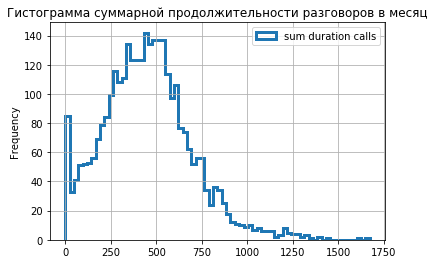

In [ ]:
data.plot(kind='hist', y='sum_duration', histtype='step', bins=70, linewidth=3, label='sum duration calls', grid=True, legend=True)
plt.title('Гистограмма суммарной продолжительности разговоров в месяц')
plt.show()

Большинство пользователей в среднем используют в месяц 400-500 минут разговора по телефону. Также стоит отметить что есть пользователи которые не используют или практически не используют телефонные звонки, поскольку в наше время многие используют интернет звонки. И соответственно есть те, кто используют в месяц и более 1000 минут разговора по телефону.

Просчитаем статистики по звонкам для нашей выборки:

In [ ]:
variance_estimate = np.var(data['sum_duration'], ddof=1)
standart_deviation = np.std(data['sum_duration'], ddof=1)
mean = data['sum_duration'].mean()
median = data['sum_duration'].median()
mean_count = data['count_calls'].mean()

display(f'Дисперсия суммарной продолжительности звонков за месяц: {variance_estimate}')
display(f'Стандартное отклонение суммарной продолжительности звонков за месяц: {standart_deviation}')
display(f'Средняя суммарная продолжительность звонков: {mean}')
display(f'Медиана суммарной продолжительности звонков: {median}')
display(f'Среднее количество звонков: {mean_count}')

'Дисперсия суммарной продолжительности звонков за месяц: 58520.43768761048'

'Стандартное отклонение суммарной продолжительности звонков за месяц: 241.9099784787938'

'Средняя суммарная продолжительность звонков: 451.2448662103298'

'Медиана суммарной продолжительности звонков: 443.0'

'Среднее количество звонков: 63.03889234598631'

###  Рассмотрим количество отправляемых сообщений

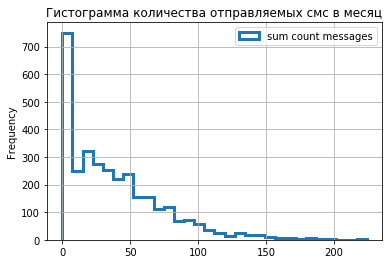

In [ ]:
data.plot(kind='hist', y='messages_count', histtype='step', bins=30, linewidth=3, label='sum count messages', grid=True, legend=True)
plt.title('Гистограмма количества отправляемых смс в месяц')
plt.show()

In [ ]:
data['messages_count'].describe()

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages_count, dtype: float64

По гистограмме и числовому описанию видно, что в среднем пользователи отправляют около 30 сообщений в месяц, но также как и со звонками есть пользователи, которые не пользуются смс вообще и есть пользователи, которые отправляют более 150 смс в месяц.

Рассчитаем статистики по этой выборке:

In [ ]:
variance_estimate = np.var(data['messages_count'], ddof=1)
standart_deviation = np.std(data['messages_count'], ddof=1)
mean = data['messages_count'].mean()
median = data['messages_count'].median()

display(f'Дисперсия суммарного количества смс за месяц: {variance_estimate}')
display(f'Стандартное отклонение суммарного количества смс за месяц: {standart_deviation}')
display(f'Средняя суммарное количество смс в месяц: {mean}')
display(f'Медиана суммарного количества смс в месяц: {median}')

'Дисперсия суммарного количества смс за месяц: 1306.7014417742482'

'Стандартное отклонение суммарного количества смс за месяц: 36.14832557358982'

'Средняя суммарное количество смс в месяц: 38.28126944617299'

'Медиана суммарного количества смс в месяц: 30.0'

###  Рассмотрим объем трафика

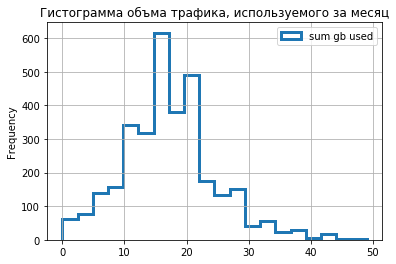

In [ ]:
data.plot(kind='hist', y='sum_gb_used', histtype='step', bins=20, linewidth=3, label='sum gb used', grid=True, legend=True)
plt.title('Гистограмма объма трафика, используемого за месяц')
plt.show()

Гистограмма объема месячного трафика показывает что в среднем пользователи используют 17 гб трафика в месяц. Как и ожидалось есть те, кто в месяц вообще не пользуются интернетом. И есть те, кому необходимо более 40 гб трафика. 

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Обрати внимание, что наши действия повторяются с точки зрения построения графиков.
    
Это говорит о том, что мы можем создать функцию, которая будет выполнять все действия за нас.
    
Тем самым мы сможем оптимизировать свой код и проект целиком.
    
</div>

Рассчитаем статистики по этой выборке:

In [ ]:
variance_estimate = np.var(data['sum_gb_used'], ddof=1)
standart_deviation = np.std(data['sum_gb_used'], ddof=1)
mean = data['sum_gb_used'].mean()
median = data['sum_gb_used'].median()

display(f'Дисперсия суммарного объема трафика за месяц: {variance_estimate}')
display(f'Стандартное отклонение суммарного объема трафика за месяц: {standart_deviation}')
display(f'Средний суммарный объем трафика в месяц: {mean}')
display(f'Медиана суммарного объема трафика в месяц: {median}')

'Дисперсия суммарного объема трафика за месяц: 54.768645133501096'

'Стандартное отклонение суммарного объема трафика за месяц: 7.40058410758915'

'Средний суммарный объем трафика в месяц: 17.29900435594275'

'Медиана суммарного объема трафика в месяц: 17.0'

**Вывод**

Мы проанализировали поведение пользователей по выборке. Результаты получились ожидаемые. 

Большинство пользователей в среднем используют в месяц 400-500 минут разговора по телефону. Также стоит отметить что есть пользователи которые не используют или практически не используют телефонные звонки, поскольку в наше время многие используют интернет звонки. И соответственно есть те, кто используют в месяц и более 1000 минут разговора по телефону.

В среднем пользователи отправляют около 30 сообщений в месяц, но также как и со звонками есть пользователи, которые не пользуются смс вообще и есть пользователи, которые отправляют более 150 смс в месяц.

Гистограмма объема месячного трафика показываает что в среднем пользователи используют 17 гб трафика в месяц. Как и ожидалось есть те, кто в месяц вообще не пользуются интернетом. И есть те, кому необходимо более 40 гб трафика.

## Проверка гипотез

Необходимо проверить 2 гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» одиннаковая.

Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» не одиннаковая.

In [ ]:
data_smart = data[data['tariff'] == 'smart']
data_ultra = data[data['tariff'] == 'ultra']

Проверим дисперсии выборок:

In [ ]:
display(np.var(data_smart['income'], ddof=1))
display(np.var(data_ultra['income'], ddof=1))

669785.7080064242

141516.7450786183

Дисперсии выборок разные, следовательно стоит поставить equal_var = False

Отобразим распределение выборок:

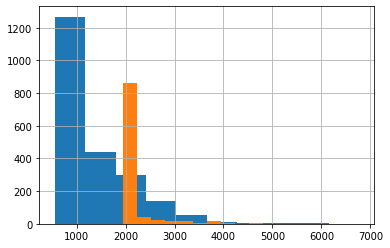

In [ ]:
display(data_smart['income'].hist(bins=10))
display(data_ultra['income'].hist(bins=10))

In [ ]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    data_smart['income'], 
    data_ultra['income'],
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


**Таким образом, можно отвергнуть гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» одиннаковая.**

### Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: средняя выручка пользователей из Москвы равна средней выручке пользователей из других городов.

Альтернативная гипотеза: средняя выручка пользователей из Москвы не равна средней выручке пользователей из других городов.

Для того чтобы провести статистический тест для этой гипотезы необходимо подготовить две выборки - пользователей из Москвы и пользователей из других городов:

In [ ]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1001,41,NaN,москва,иван,ежов,2018-11-01,smart
2,1002,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart
3,1003,23,NaN,москва,белла,белякова,2018-08-17,ultra
4,1004,68,NaN,новокузнецк,татьяна,авдеенко,2018-05-14,ultra


In [ ]:
users_new = users[['user_id', 'city']]
users_new.head()

,user_id,city
0,1000,краснодар
1,1001,москва
2,1002,стерлитамак
3,1003,москва
4,1004,новокузнецк


In [ ]:
data = data.merge(users_new, on=['user_id'])
data.head()

,user_id,month,sum_mb_used,sum_gb_used,count_calls,sum_duration,messages_count,tariff,income,city
0,1000,2018-05,2253.49,3.0,22.0,159.0,22.0,ultra,1950.0,краснодар
1,1000,2018-06,23233.77,23.0,43.0,172.0,60.0,ultra,1950.0,краснодар
2,1000,2018-07,14003.64,14.0,47.0,340.0,75.0,ultra,1950.0,краснодар
3,1000,2018-08,14055.93,14.0,52.0,408.0,81.0,ultra,1950.0,краснодар
4,1000,2018-09,14568.91,15.0,58.0,466.0,57.0,ultra,1950.0,краснодар


In [ ]:
data_msk = data[data['city'] == 'москва']
data_regions = data[data['city'] != 'москва']

In [ ]:
data_msk.head()

,user_id,month,sum_mb_used,sum_gb_used,count_calls,sum_duration,messages_count,tariff,income,city
8,1001,2018-11,18429.34,18.0,59.0,430.0,0.0,smart,1150.0,москва
9,1001,2018-12,14036.66,14.0,63.0,414.0,0.0,smart,550.0,москва
17,1003,2018-08,8565.21,9.0,55.0,380.0,37.0,ultra,1950.0,москва
18,1003,2018-09,12468.87,13.0,134.0,961.0,91.0,ultra,1950.0,москва
19,1003,2018-10,14768.14,15.0,108.0,855.0,83.0,ultra,1950.0,москва


In [ ]:
data_regions.head()

,user_id,month,sum_mb_used,sum_gb_used,count_calls,sum_duration,messages_count,tariff,income,city
0,1000,2018-05,2253.49,3.0,22.0,159.0,22.0,ultra,1950.0,краснодар
1,1000,2018-06,23233.77,23.0,43.0,172.0,60.0,ultra,1950.0,краснодар
2,1000,2018-07,14003.64,14.0,47.0,340.0,75.0,ultra,1950.0,краснодар
3,1000,2018-08,14055.93,14.0,52.0,408.0,81.0,ultra,1950.0,краснодар
4,1000,2018-09,14568.91,15.0,58.0,466.0,57.0,ultra,1950.0,краснодар


Проверим дисперсии выборок:

In [ ]:
display(np.var(data_msk['income'], ddof=1))
display(np.var(data_regions['income'], ddof=1))

565636.467011886

654137.6285218114

Дисперсии выборок близки друг к другу, поэтому параметр  equal_var менять не будем.

Отобразим распределение выборок:

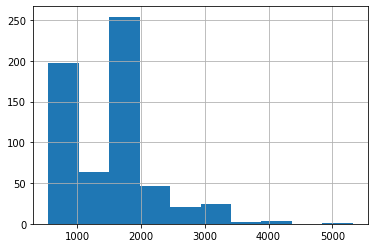

In [ ]:
display(data_msk['income'].hist(bins=10))

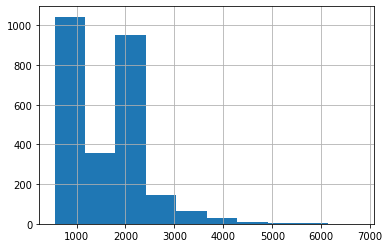

In [ ]:
display(data_regions['income'].hist(bins=10))

Проведем статистический тест:

In [ ]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    data_msk['income'], 
    data_regions['income'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


**Таким образом, отвергнуть гипотезу о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других городов не получилось**

**Вывод**

Мы анализировали 2 гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Результаты двух статистических тестов показали, что:
- нельзя отвергать гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
- можно отвергнуть гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Общий вывод

В этом проекте нам необходимо было поработать с выборкой информации о клиентах телефонного оператора. Информация была представлена пятью таблицами: информация о пользователях, информация о звонках, информация о сообщениях, информация о интернет трафике, информация о самимх тарифах.

Мы начали свое исследование с тщательной предобработки данных. Выявили такие проблемы как неудобные типы данных. Проблемы были устранены и мы перешли к дальнейшему анализу.

Сначала мы добавили в каждую из таблиц рассчетные характеристики, такие как количество затраченных минут, смс, мегабайт интернета для каждого пользователя по месяцам. Далее составили функцию и рассчитали какой доход мобильному оператору приносит каждый пользователь в каждый месяц. После этого можно было объединить таблицы в одну и перейти к исследованию.

**Исследование показало:**

Большинство пользователей в среднем используют в месяц 400-500 минут разговора по телефону. Также стоит отметить что есть пользователи которые не используют или практически не используют телефонные звонки, поскольку в наше время многие используют интернет звонки. И соответственно есть те, кто используют в месяц и более 1000 минут разговора по телефону.

В среднем пользователи отправляют около 30 сообщений в месяц, но также как и со звонками есть пользователи, которые не пользуются смс вообще и есть пользователи, которые отправляют более 150 смс в месяц.

Гистограмма объема месячного трафика показываает что в среднем пользователи используют 17 гб трафика в месяц. Как и ожидалось есть те, кто в месяц вообще не пользуются интернетом. И есть те, кому необходимо более 40 гб трафика.

**Также необходимо было проверить две гипотезы:**
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Мы подготовили данные и провели статистические тесты с этими выборками. Результаты статистических тестов показали:
- нельзя отвергать гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
- можно отвергнуть гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.